# Phase 1 on METABRIC dataset

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

### Reading dataset

In [3]:
df = pd.read_csv("Data/METABRIC_RNA_Mutation.csv", usecols=range(31))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

### Percentage of missing values in each column

In [5]:
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
percent

tumor_stage                       0.263130
3-gene_classifier_subtype         0.107143
primary_tumor_laterality          0.055672
neoplasm_histologic_grade         0.037815
cellularity                       0.028361
mutation_count                    0.023634
er_status_measured_by_ihc         0.015756
type_of_breast_surgery            0.011555
tumor_size                        0.010504
cancer_type_detailed              0.007878
tumor_other_histologic_subtype    0.007878
oncotree_code                     0.007878
death_from_cancer                 0.000525
radio_therapy                     0.000000
lymph_nodes_examined_positive     0.000000
pr_status                         0.000000
overall_survival                  0.000000
overall_survival_months           0.000000
nottingham_prognostic_index       0.000000
patient_id                        0.000000
integrative_cluster               0.000000
inferred_menopausal_state         0.000000
age_at_diagnosis                  0.000000
her2_status

### Number of missing values

In [6]:
print(f"No of samples before dropping NaNs {df.shape[0]}, No of samples after dropping NaNs: {df.dropna().shape[0]}")

No of samples before dropping NaNs 1904, No of samples after dropping NaNs: 1092


### Standard form

In [7]:
def to_standard(df):
    
    num_df = df[df.select_dtypes(include = np.number).columns.tolist()]
    
    ss = StandardScaler()
    std = ss.fit_transform(num_df)
    
    std_df = pd.DataFrame(std, index = num_df.index, columns = num_df.columns)
    return std_df

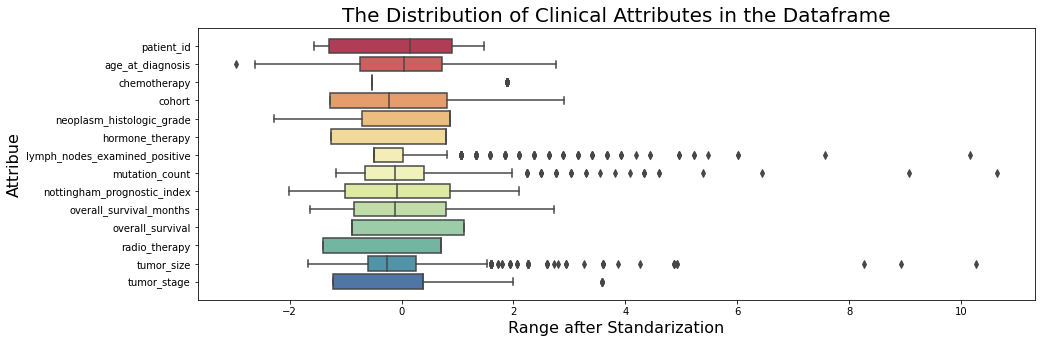

In [8]:
df = df.dropna()

ax, fig = plt.subplots(1, 1, figsize = (15, 5))
plt.title('The Distribution of Clinical Attributes in the Dataframe', fontsize = 20) #Change please

sns.boxplot(y = "variable", x = "value", data = pd.melt(to_standard(df)), palette = 'Spectral')
plt.xlabel('Range after Standarization', size = 16)
plt.ylabel('Attribue', size = 16)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [9]:
mask_df = (df[['tumor_size', 'mutation_count', 'lymph_nodes_examined_positive']].apply(zscore) < 3)
mask_df['Drop'] = True
for col in mask_df:
    mask_df['Drop'] &= mask_df[f"{col}"]
df_zscore = df[mask_df['Drop']]
print("df shape: ", df.shape)
print("df after zscore shape: ", df_zscore.shape)
print("Number of outliers that have been removed: ", df.shape[0]-df_zscore.shape[0])

df shape:  (1092, 31)
df after zscore shape:  (1034, 31)
Number of outliers that have been removed:  58


In [10]:
Q1 = df['tumor_size'].quantile(0.25)
Q3 = df['tumor_size'].quantile(0.75)
IQR = Q3 - Q1
filtered = df.query(f'(@Q1 - 1.5 * @IQR) <= tumor_size <= (@Q3 + 1.5 * @IQR)')
Q1 = filtered['mutation_count'].quantile(0.25)
Q3 = filtered['mutation_count'].quantile(0.75)
IQR = Q3 - Q1
filtered = filtered.query(f'(@Q1 - 1.5 * @IQR) <= mutation_count <= (@Q3 + 1.5 * @IQR)')
Q1 = filtered['lymph_nodes_examined_positive'].quantile(0.25)
Q3 = filtered['lymph_nodes_examined_positive'].quantile(0.75)
IQR = Q3 - Q1
df_IQR = filtered.query(f'(@Q1 - 1.5 * @IQR) <= lymph_nodes_examined_positive <= (@Q3 + 1.5 * @IQR)')
print("df shape: ", df.shape)
print("df after IQR shape: ", df_IQR.shape)
print("Number of outliers that have been removed: ", df.shape[0]-df_IQR.shape[0])

df shape:  (1092, 31)
df after IQR shape:  (901, 31)
Number of outliers that have been removed:  191


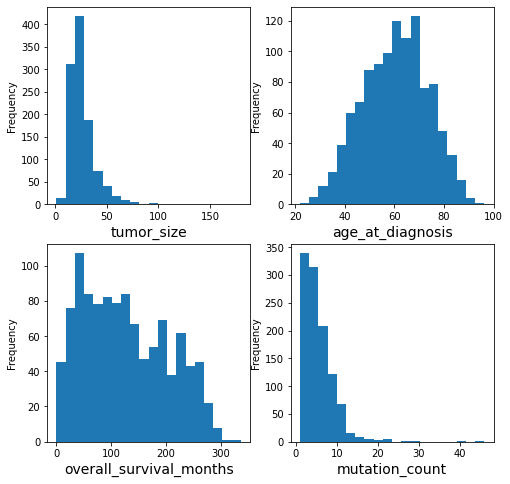

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

i, j = 0, 0
for col in df[['tumor_size', 'age_at_diagnosis', 'overall_survival_months', 'mutation_count']]:
    if j == 2:
        j = 0
        i = 1
    df[col].plot(kind='hist', bins=20, ax=ax[i, j])
    ax[i,j].set_xlabel(col, size=14)
    j += 1

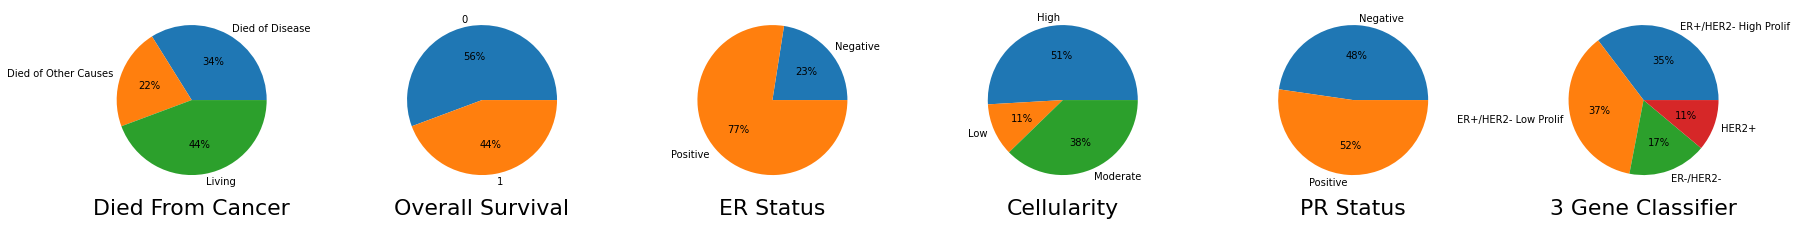

In [12]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, figsize=(25, 25))
df.groupby('death_from_cancer').size().plot(kind='pie', autopct='%1.0f%%', ax=ax1)
df.groupby('overall_survival').size().plot(kind='pie', autopct='%1.0f%%', ax=ax2)
df.groupby('er_status').size().plot(kind='pie', autopct='%1.0f%%', ax=ax3)
df.groupby('cellularity').size().plot(kind='pie', autopct='%1.0f%%', ax=ax4)
df.groupby('pr_status').size().plot(kind='pie', autopct='%1.0f%%', ax=ax5)
df.groupby('3-gene_classifier_subtype').size().plot(kind='pie', autopct='%1.0f%%', ax=ax6)

fig.patch.set_facecolor('xkcd:white')

ax1.set_xlabel('Died From Cancer', size=22)
ax2.set_xlabel('Overall Survival', size=22)
ax3.set_xlabel('ER Status', size=22)
ax4.set_xlabel('Cellularity', size=22)
ax5.set_xlabel('PR Status', size=22)
ax6.set_xlabel('3 Gene Classifier', size=22)
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
plt.tight_layout()
plt.show()

In [13]:
import jenkspy
columns = ['tumor_size', 'age_at_diagnosis', 'overall_survival_months', 'mutation_count']
for col in columns:
    breaks = jenkspy.jenks_breaks(df[col], nb_class=3)
    df[f'{col}_natural_breaks'] = pd.cut(df[col], bins=breaks, 
                                         labels=[f'{breaks[0]}, {breaks[1]}', f'{breaks[1]:.2f}, {breaks[2]:.2f}', f'{breaks[2]:.2f}, {breaks[3]:.2f}'], 
                                         include_lowest=True)

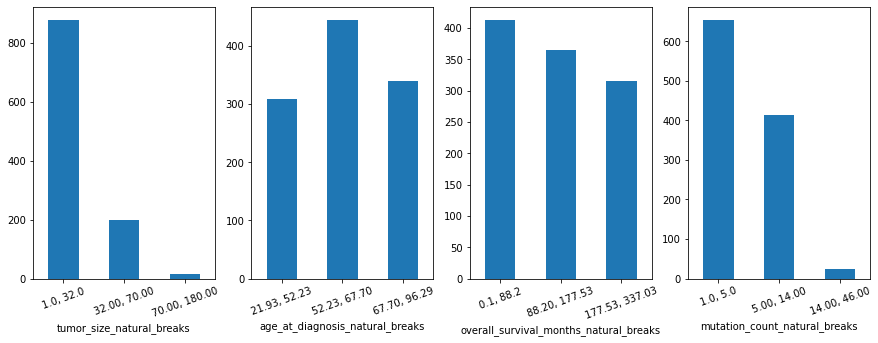

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 5))

columns = ['tumor_size_natural_breaks', 'age_at_diagnosis_natural_breaks', 'overall_survival_months_natural_breaks', 'mutation_count_natural_breaks']
j = 0
for col in columns:
    df.groupby(col).size().plot(kind='bar', ax=ax[j], rot=20)
    ax[j].set_xlabel(col, size=10)
    j+=1

In [15]:
to_standard(df)

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
1,-1.567516,-1.323860,-0.532162,-1.278292,0.871014,0.793631,-0.490800,-0.911111,-0.102808,-0.543610,1.120803,0.711482,-1.067942,-1.215941
4,-1.564638,1.275606,1.879128,-1.278292,0.871014,0.793631,1.587545,-0.911111,1.840645,-1.104789,-0.892218,0.711482,0.931303,0.385757
5,-1.563679,1.414121,-0.532162,-1.278292,0.871014,0.793631,-0.490800,-0.386219,-0.063184,-1.540157,-0.892218,0.711482,0.331529,3.589154
8,-1.555045,2.002041,-0.532162,-1.278292,0.871014,0.793631,-0.231006,-0.386219,0.851937,-1.167046,-0.892218,0.711482,-0.668093,0.385757
9,-1.551688,1.833514,-0.532162,-1.278292,-0.701130,-1.260031,-0.490800,-0.123773,-1.012269,-1.170937,-0.892218,-1.405517,0.131605,0.385757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,1.420676,0.833128,-0.532162,2.910440,-0.701130,0.793631,0.548373,1.450904,0.878353,-0.538854,-0.892218,-1.405517,0.264888,0.385757
1619,1.421156,0.789265,-0.532162,2.910440,-2.273275,-1.260031,-0.490800,0.926012,-1.970787,0.967855,1.120803,0.711482,-0.401527,-1.215941
1621,1.423074,1.171720,-0.532162,2.910440,0.871014,-1.260031,-0.490800,-0.386219,-0.083940,-0.276856,-0.892218,-1.405517,-0.401527,-1.215941
1623,1.424034,-0.581265,1.879128,2.910440,-0.701130,-1.260031,1.067959,-0.123773,0.859484,0.957046,1.120803,0.711482,-0.401527,0.385757


In [16]:
df = pd.DataFrame(df_zscore)

In [17]:
# Convert Categorical Data to Numerical
df['pr_status'] = np.where(df["pr_status"] == 'Positive', 1, -1)
df['er_status'] = np.where(df["er_status"] == 'Positive', 1, -1)
df['her2_status'] = np.where(df["her2_status"] == 'Positive', 1, -1)
df['er_status_measured_by_ihc'] = np.where(df['er_status_measured_by_ihc'] == 'Positve', 1, -1)
df['cellularity'] = np.select([df['cellularity'] == 'High', df['cellularity'] == 'Moderate', df['cellularity'] == 'Low'], [2, 1, 0])

one_hot = pd.get_dummies(df['3-gene_classifier_subtype'])
df.drop(['3-gene_classifier_subtype'], axis=1, inplace=True)
df = df.join(one_hot)

In [18]:
df = df.drop(['patient_id', 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 
        'pam50_+_claudin-low_subtype', 'tumor_other_histologic_subtype', 'her2_status_measured_by_snp6', 'inferred_menopausal_state',
        'death_from_cancer', 'oncotree_code', 'integrative_cluster', 'primary_tumor_laterality'], axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034 entries, 1 to 1664
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age_at_diagnosis               1034 non-null   float64
 1   cellularity                    1034 non-null   int32  
 2   chemotherapy                   1034 non-null   int64  
 3   cohort                         1034 non-null   float64
 4   er_status_measured_by_ihc      1034 non-null   int32  
 5   er_status                      1034 non-null   int32  
 6   neoplasm_histologic_grade      1034 non-null   float64
 7   her2_status                    1034 non-null   int32  
 8   hormone_therapy                1034 non-null   int64  
 9   lymph_nodes_examined_positive  1034 non-null   float64
 10  mutation_count                 1034 non-null   float64
 11  nottingham_prognostic_index    1034 non-null   float64
 12  overall_survival_months        1034 non-null   f

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034 entries, 1 to 1664
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age_at_diagnosis               1034 non-null   float64
 1   cellularity                    1034 non-null   int32  
 2   chemotherapy                   1034 non-null   int64  
 3   cohort                         1034 non-null   float64
 4   er_status_measured_by_ihc      1034 non-null   int32  
 5   er_status                      1034 non-null   int32  
 6   neoplasm_histologic_grade      1034 non-null   float64
 7   her2_status                    1034 non-null   int32  
 8   hormone_therapy                1034 non-null   int64  
 9   lymph_nodes_examined_positive  1034 non-null   float64
 10  mutation_count                 1034 non-null   float64
 11  nottingham_prognostic_index    1034 non-null   float64
 12  overall_survival_months        1034 non-null   f

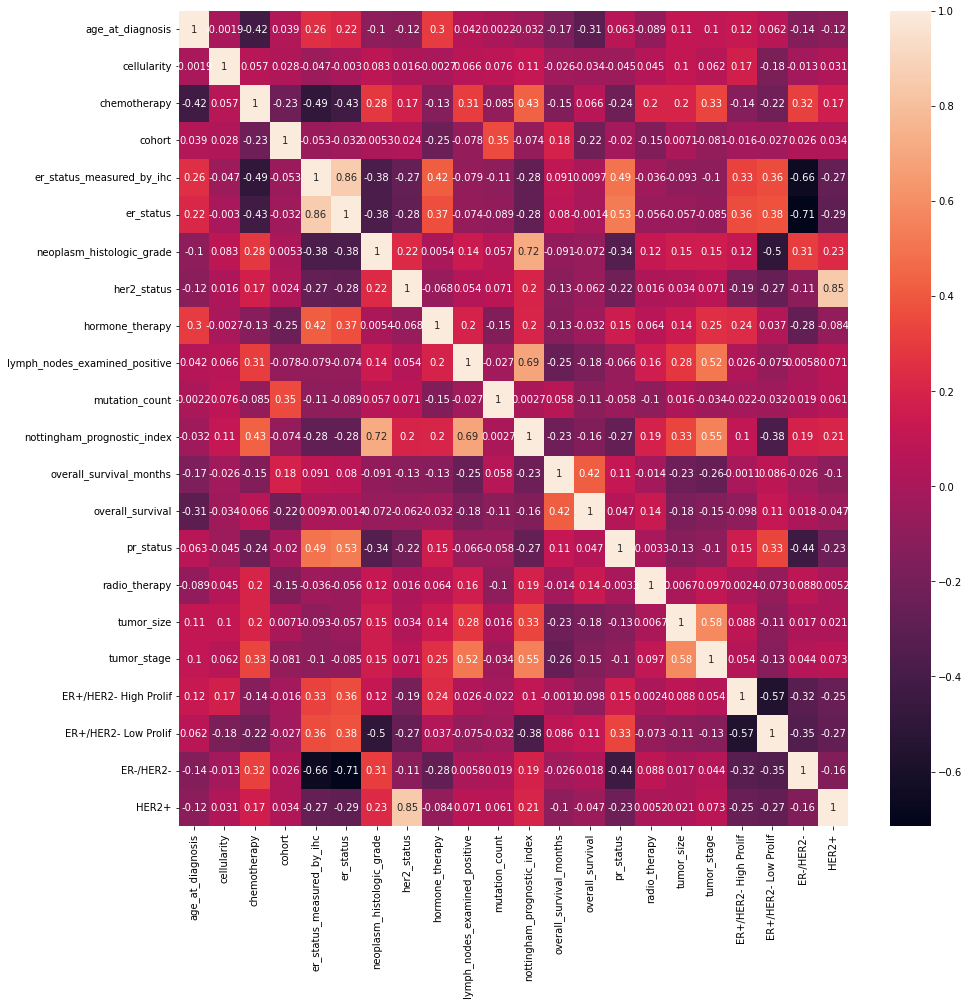

In [21]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True);

In [22]:
from sklearn.model_selection import StratifiedKFold

# using a stratfied k fold because we need the distribution of the to classes in all of the folds to be the same.
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
print('Baseline accuracy:' )
print(df["overall_survival"].value_counts()/df["overall_survival"].count())

Baseline accuracy:
0    0.54352
1    0.45648
Name: overall_survival, dtype: float64


In [24]:
from sklearn.model_selection import train_test_split

X = df.drop(['overall_survival'], axis=1)
Y = df['overall_survival']

# using stratify for y because we need the distribution of the two classes to be equal in train and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [25]:
x_train

,age_at_diagnosis,cellularity,chemotherapy,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status,hormone_therapy,lymph_nodes_examined_positive,...,nottingham_prognostic_index,overall_survival_months,pr_status,radio_therapy,tumor_size,tumor_stage,ER+/HER2- High Prolif,ER+/HER2- Low Prolif,ER-/HER2-,HER2+
48,76.89,1,0,1.0,1,1,3.0,-1,1,0.0,...,4.050,114.233333,1,0,25.0,2.0,1,0,0,0
1475,81.63,2,0,3.0,1,1,2.0,-1,1,1.0,...,4.064,128.200000,1,1,32.0,2.0,0,1,0,0
1217,52.43,1,0,3.0,-1,-1,3.0,-1,0,0.0,...,4.054,151.900000,-1,0,27.0,2.0,0,0,1,0
216,81.88,2,0,1.0,1,1,1.0,-1,1,0.0,...,2.044,122.700000,1,1,22.0,2.0,0,1,0,0
595,43.08,2,0,2.0,1,1,2.0,-1,0,0.0,...,3.036,30.133333,1,1,18.0,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,54.18,2,0,3.0,-1,-1,3.0,-1,0,0.0,...,4.040,158.966667,1,0,20.0,1.0,0,0,1,0
327,57.57,2,1,1.0,1,1,3.0,-1,1,0.0,...,4.064,89.966667,1,1,32.0,2.0,0,1,0,0
1339,85.94,2,0,3.0,1,1,2.0,-1,1,10.0,...,5.050,95.733333,1,0,25.0,2.0,0,1,0,0
1149,63.24,0,0,3.0,1,1,2.0,-1,0,0.0,...,3.022,204.433333,1,1,11.0,1.0,1,0,0,0


In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

BOLD = '\033[1m'
END = '\033[0m'

## KNN Model

Model = KNN 
CV scores:  [0.76506024 0.69277108 0.75757576 0.75757576 0.73333333]
CV Mean score:  0.7412632347572107
Classification Report:  
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       113
           1       0.67      0.79      0.73        94

    accuracy                           0.73       207
   macro avg       0.73      0.73      0.73       207
weighted avg       0.74      0.73      0.73       207

Model's score on train data : 1.0
Model's score on test data :  0.7294685990338164
Best KNN model parameters: 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 30, 'p': 2, 'weights': 'distance'}


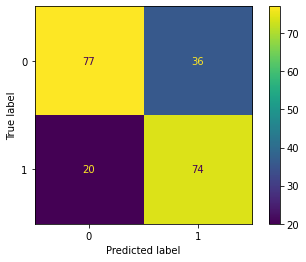

In [27]:
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
}

model = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, cv=4).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)


print(BOLD + "Model = KNN", END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print("Best KNN model parameters: ")
print(model.best_estimator_.get_params())
disp.plot();

Model = Logistice Regression
CV scores:  [0.75301205 0.71686747 0.76969697 0.81212121 0.73939394]
CV Mean score:  0.758218327856882
Classification Report:  
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       113
           1       0.74      0.80      0.77        94

    accuracy                           0.78       207
   macro avg       0.78      0.78      0.78       207
weighted avg       0.78      0.78      0.78       207

Model's score on train data : 0.7629987908101572
Model's score on test data :  0.7777777777777778
Best Logistice Regression model parameters: 
{'C': 0.18947368421052632, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


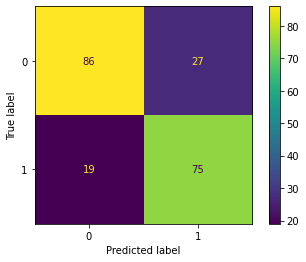

In [37]:
MODEL = "Logistic Regression"
params = {
    "C" : np.linspace(0.1, 1.8, 20)
}
model = GridSearchCV(LogisticRegression(max_iter=10000), params, n_jobs=-1, cv=4).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)


print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.best_estimator_.get_params())
disp.plot();

Model = Decision Tree Classifier
CV scores:  [0.68674699 0.68072289 0.71515152 0.72727273 0.73333333]
CV Mean score:  0.7086454910551296
Classification Report:  
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       113
           1       0.67      0.73      0.70        94

    accuracy                           0.71       207
   macro avg       0.71      0.72      0.71       207
weighted avg       0.72      0.71      0.72       207

Model's score on train data : 1.0
Model's score on test data :  0.714975845410628
Best Decision Tree Classifier model parameters: 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


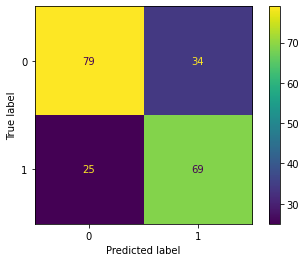

In [42]:
MODEL = "Decision Tree Classifier"

model = DecisionTreeClassifier().fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)


print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.get_params())
disp.plot();

Model = Random Forest Classifier
CV scores:  [0.80722892 0.74096386 0.76363636 0.79393939 0.73333333]
CV Mean score:  0.7678203723986857
Classification Report:  
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       113
           1       0.77      0.84      0.81        94

    accuracy                           0.82       207
   macro avg       0.82      0.82      0.82       207
weighted avg       0.82      0.82      0.82       207

Model's score on train data : 1.0
Model's score on test data :  0.8164251207729468
Best Random Forest Classifier model parameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_s

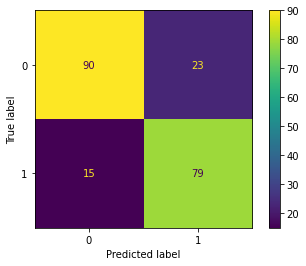

In [45]:
MODEL = "Random Forest Classifier"

model = RandomForestClassifier().fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)


print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.get_params())
disp.plot();

In [48]:
MODEL = "MLP Classifier"

params = {
    "hidden_layer_sizes" : [(100, 100, 50, 50, 10), (100, 200, 100, 50, 10), (150, 100, 70, 50, 10)],
    "solver" : ['sgd', 'adam'],
    "alpha" : [1e-4, 1e-3, 1e-2, 1e-1, 1],
    "learning_rate_init" : [1e-3, 1e-2, 1e-1, 1e-4],
    "max_iter" : [1000,]
}
model = GridSearchCV(MLPClassifier(), params, n_jobs=-1, cv=4).fit(x_train, y_train)
pred = model.predict(x_test)
results = cross_val_score(model, x_train, y_train, cv=kfold)


print(BOLD + f"Model = {MODEL}" + END)
print("CV scores: ", results)
print("CV Mean score: ", results.mean())
print('Classification Report:  ')
print(classification_report(y_test, pred))
print("Model's score on train data :", model.score(x_train, y_train))
print("Model's score on test data : ", model.score(x_test, y_test))
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
print(f"Best {MODEL} model parameters: ")
print(model.best_estimator_.get_params())
disp.plot();